<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/eda_credit_default.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA of Credit Default 

## Goal

To predict whether the customer will default on their credit card payment next month.

This exploratory data analysis should assits to:
1. Understand variable relations within the underlyind data.
2. Identity data transformations required for modeling
3. Identify any required data cleaning
4. Generate research questions 

## Dataset

This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.

> Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480.
https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

In [1]:
#@title ##Setup
#@markdown Import data manipulation and plotting dependencies.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


### Dataset columns:

Total 25 columns, with 1 target variable ```default.payment.next.month```, and 23 explanatory variables (ID excluded).

- **LIMIT_BAL:** Amount of given credit
- **SEX, EDUCATION**, MARRIAGE, AGE: client demographic features
- **PAY[1-6]:** repayment status
- **BILL_AMT[1-6]:** amount on bill statement
- **PAY_AMT[1-6]:** payment amount
- **default payment next month:** target, whether the client defaulted the following month

In [13]:
# Load the data
data_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
df = pd.read_excel(io=data_url, header=1)
df = df.drop(columns=['ID'])
df = df.rename(columns={'default payment next month': 'DEFAULT', 'PAY_0':'PAY_1'})
fill = (df.EDUCATION == 0) | (df.EDUCATION == 5) | (df.EDUCATION == 6)
df.loc[fill, 'EDUCATION'] = 4
df.sample(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
10341,240000,1,1,3,65,0,0,0,-1,-1,-1,4110,5000,0,1000,0,167747,1000,0,1000,0,167747,4810,0
8446,80000,1,1,2,29,1,2,2,-2,-2,-2,49373,49812,0,0,0,0,1980,19800,0,0,0,0,1
16594,10000,1,2,2,28,-1,2,-1,2,3,2,619,619,8642,9151,8023,5475,0,8642,800,107,200,0,1
23276,300000,2,2,1,42,0,0,0,0,0,0,168796,165430,147077,127270,129397,132142,7010,6000,5006,5000,5000,6000,0
27435,210000,1,1,2,32,0,0,0,0,0,0,218742,218317,73874,73219,96844,94731,10000,5000,5000,30000,4500,15000,0


In [3]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_1,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0
PAY_5,30000.0,-0.266200,1.133187,-2.0,-1.00,0.0,0.00,8.0


- Unbalanced dataset. Customer default(default payment next month) shows 22% samples labeled as default.

- Repayment status ```PAY[1-6]``` shows that at least 75% of clients are paying their credit card bill on time.

### Relation between ```default``` and other variables

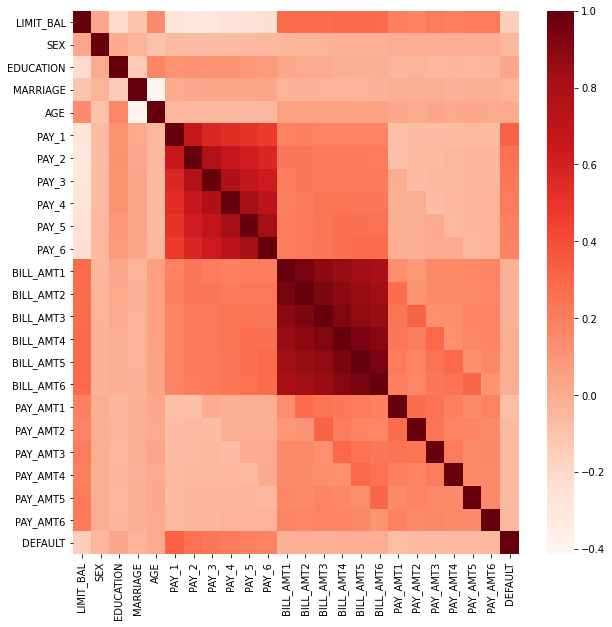

In [4]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), cmap='Reds');

### Education vs. ```default```



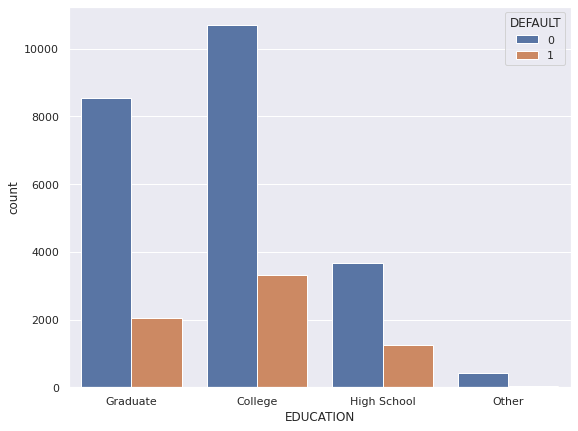

In [14]:
sns.set(rc={'figure.figsize':(9,7)})
edu = sns.countplot(x='EDUCATION', hue='DEFAULT', data=df)
edu.set_xticklabels(['Graduate','College','High School','Other']);

In [16]:
default0 = df.groupby(df['EDUCATION'][df['DEFAULT'] == 0]).size().reset_index(name='NOT_DEFAULT')
default1 = df.groupby(df['EDUCATION'][df['DEFAULT'] == 1]).size().reset_index(name='DEFAULT')
total = df.groupby('EDUCATION').size().reset_index(name='TOTAL')

eduTable = default0.join(default1['DEFAULT']).join(total['TOTAL'])
eduTable['EDUCATION'] = ['Graduate School','University','High School','Other']

eduTable['NOT_DEFAULT'] = round((default0['NOT_DEFAULT']/total['TOTAL'])*100,2)
eduTable['DEFAULT'] = round((default1['DEFAULT']/total['TOTAL'])*100,2)

eduPct = eduTable.iloc[:,0:3]
eduPct = eduPct.rename(columns={'NOT_DEFAULT': 'NOT_DEFAULT(%)', 'DEFAULT': 'DEFAULT(%)'})

eduPct

,EDUCATION,NOT_DEFAULT(%),DEFAULT(%)
0,Graduate School,80.77,19.23
1,University,76.27,23.73
2,High School,74.84,25.16
3,Other,92.95,7.05


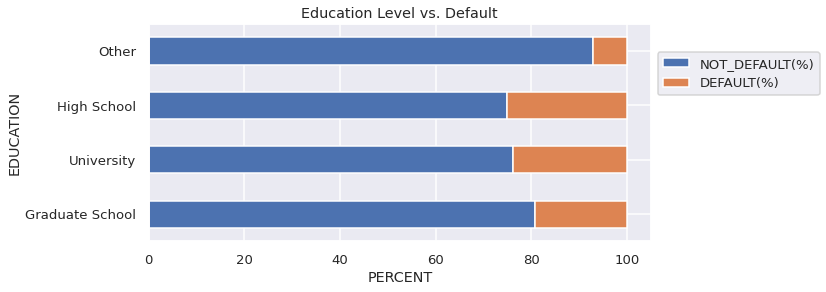

In [17]:
sns.set(rc={'figure.figsize':(9,4)})
sns.set_context("talk", font_scale=0.8)

ax = eduPct.plot(x='EDUCATION', kind='barh', stacked=True, title='Education Level vs. Default')
ax.set_xlabel('PERCENT')
ax.get_legend().set_bbox_to_anchor((1, 0.9))

There seems to be a correlation between lower levels of education and ```default```.

### Marriage vs. ```default```

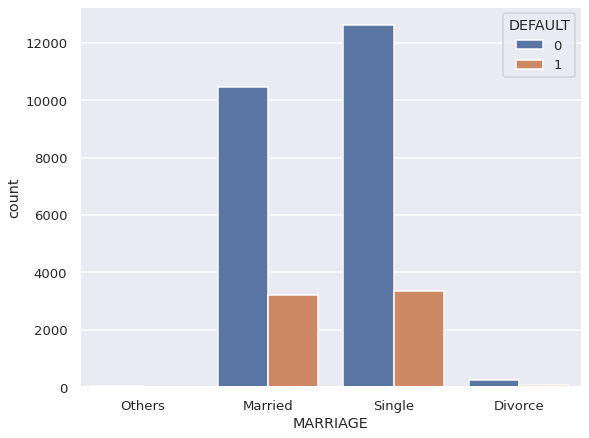

In [19]:
sns.set(rc={'figure.figsize':(9,7)})
sns.set_context("talk", font_scale=0.8)

marri = sns.countplot(x="MARRIAGE", hue='DEFAULT', data=df )
marri.set_xticklabels(['Others','Married','Single','Divorce']);

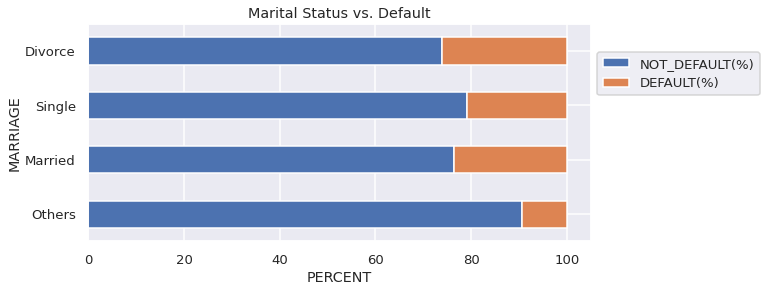

In [22]:
default0 = df.groupby(df['MARRIAGE'][df['DEFAULT'] == 0]).size().reset_index(name='NOT_DEFAULT')
default1 = df.groupby(df['MARRIAGE'][df['DEFAULT'] == 1]).size().reset_index(name='DEFAULT')
total = df.groupby('MARRIAGE').size().reset_index(name='TOTAL')

marriTable = default0.join(default1['DEFAULT']).join(total['TOTAL'])
marriTable['MARRIAGE'] = ['Others','Married','Single','Divorce']

marriTable['NOT_DEFAULT'] = round((default0['NOT_DEFAULT']/total['TOTAL'])*100,2)
marriTable['DEFAULT'] = round((default1['DEFAULT']/total['TOTAL'])*100,2)

marriPct = marriTable.iloc[:,0:3]
marriPct = marriPct.rename(columns={'NOT_DEFAULT': 'NOT_DEFAULT(%)', 'DEFAULT': 'DEFAULT(%)'})

sns.set(rc={'figure.figsize':(9,4)})
sns.set_context("talk", font_scale=0.8)

ax = marriPct.plot(x='MARRIAGE', kind='barh', stacked=True, title='Marital Status vs. Default')
ax.set_xlabel('PERCENT')
ax.get_legend().set_bbox_to_anchor((1, 0.9))

Among those with Divorce status there's a higher prevalence to default.

### Credit Behaivour vs. ```default```

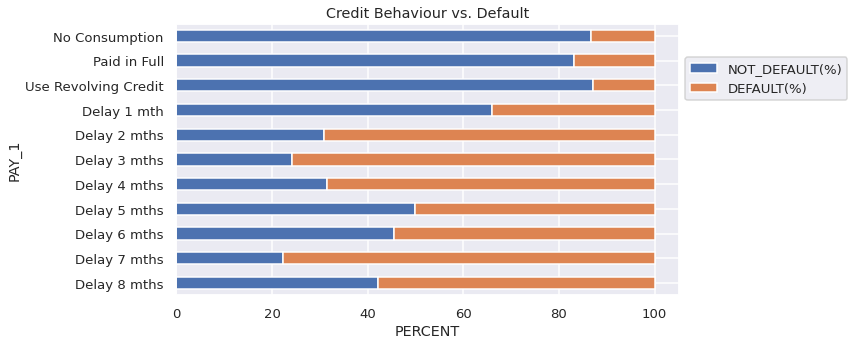

In [24]:
default0 = df.groupby(df['PAY_1'][df['DEFAULT'] == 0]).size().reset_index(name='NOT_DEFAULT')
default1 = df.groupby(df['PAY_1'][df['DEFAULT'] == 1]).size().reset_index(name='DEFAULT')
total = df.groupby('PAY_1').size().reset_index(name='TOTAL')

pay1Table = default0.join(default1['DEFAULT']).join(total['TOTAL'])
pay1Table['PAY_1'] = ['No Consumption','Paid in Full','Use Revolving Credit','Delay 1 mth','Delay 2 mths'
                     ,'Delay 3 mths','Delay 4 mths','Delay 5 mths','Delay 6 mths','Delay 7 mths','Delay 8 mths']

pay1Table['NOT_DEFAULT'] = round((default0['NOT_DEFAULT']/total['TOTAL'])*100,2)
pay1Table['DEFAULT'] = round((default1['DEFAULT']/total['TOTAL'])*100,2)

pay1Pct = pay1Table.iloc[:,0:3]
pay1Pct = pay1Pct.rename(columns={'NOT_DEFAULT': 'NOT_DEFAULT(%)', 'DEFAULT': 'DEFAULT(%)'})

sns.set(rc={'figure.figsize':(9,5)})
sns.set_context("talk", font_scale=0.8)

ax = pay1Pct.sort_index(ascending=False).plot(x='PAY_1', kind='barh', stacked=True, title='Credit Behaviour vs. Default')
ax.set_xlabel('PERCENT')
ax.get_legend().set_bbox_to_anchor((1, 0.9))
plt.show()

Those with delayed payments for more than 2 months have higher changes to default.

```
Contradicting information:
- Those who paid in full are labeled as default. 
- There are instances where billed amount exceed the credit limit. Further data cleaning might be required.
```

## Age vs. ```default```



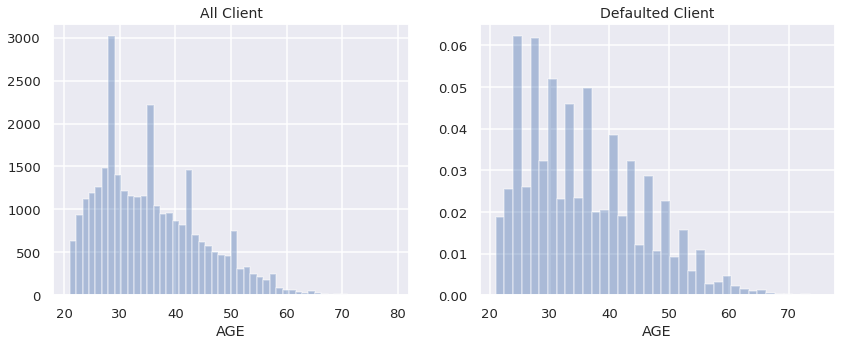

In [25]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,5))

ax1.set_title('All Client', fontsize=14)
ax2.set_title('Defaulted Client', fontsize=14)

sns.distplot(df['AGE'], norm_hist=False, kde=False, ax=ax1);
sns.distplot(df['AGE'][df['DEFAULT'] == 1], norm_hist=True, kde=False, ax=ax2);

There is a slight spike in the number of defaults between the age group 26 t0 35, but the default distribution seems to be uniform in the group 21 to 40.

## Conclusions

- Credit behaivour manifested in delay status seems the most important indicator for default.

- Demographic data seems to have a lower correlation with ```default```. 
  - Those with divorse status show higher chance to default.
  - Lower education levels show higher chance to defailt.
  - There's a slight higher chance to default for the age group 26 to 35.

## Research questions

National consumer protection agencies enforces equal credit opportunity laws in different countries, which generally prohibits credit discrimination on the basis of sex, marital status or age.

- Is there a correlation between sex, age, mariages and the credit approval status? 

- Can this relationship be used to predict if a person is in risk of default(grant credit status)?
 
- If yes, does the relationship indicate reasonable risk management strategies?
